# Initial analysis and data preprocessing 

This analysis is based on data for city bikes in Toronto, Canada for 2018.

Bike Share Toronto: https://bikesharetoronto.com/

Data source: https://www.kaggle.com/jackywang529/toronto-bikeshare-data [10.02.2020]

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
%matplotlib inline

The data is divided into quarters. The whole year 2018 will be taken into account in this analysis, so I merge the data into one table.

In [177]:
df1 = pd.read_csv('Bike Share Toronto Ridership_Q1 2018.csv', low_memory=False)
df2 = pd.read_csv('Bike Share Toronto Ridership_Q2 2018.csv', low_memory=False)
df3 = pd.read_csv('Bike Share Toronto Ridership_Q3 2018.csv', low_memory=False)
df4 = pd.read_csv('Bike Share Toronto Ridership_Q4 2018.csv', low_memory=False)

df = pd.concat([df1, df2, df3, df4], axis=0)
df.set_index('trip_id', inplace=True)

In [178]:
df.head()

,trip_duration_seconds,from_station_id,trip_start_time,from_station_name,trip_stop_time,to_station_id,to_station_name,user_type
trip_id,,,,,,,,
2383648,393,7018,1/1/2018 0:47,Bremner Blvd / Rees St,1/1/2018 0:54,7176,Bathurst St / Fort York Blvd,Annual Member
2383649,625,7184,1/1/2018 0:52,Ossington Ave / College St,1/1/2018 1:03,7191,Central Tech (Harbord St),Annual Member
2383650,233,7235,1/1/2018 0:55,Bay St / College St (West Side) - SMART,1/1/2018 0:59,7021,Bay St / Albert St,Annual Member
2383651,1138,7202,1/1/2018 0:57,Queen St W / York St (City Hall),1/1/2018 1:16,7020,Phoebe St / Spadina Ave,Annual Member
2383652,703,7004,1/1/2018 1:00,University Ave / Elm St,1/1/2018 1:12,7060,Princess St / Adelaide St E,Annual Member


In [179]:
df.shape

(1922955, 8)

In [180]:
df.isnull().sum()

trip_duration_seconds    0
from_station_id          0
trip_start_time          0
from_station_name        0
trip_stop_time           0
to_station_id            0
to_station_name          0
user_type                0
dtype: int64

In [181]:
df.nunique()

trip_duration_seconds     17609
from_station_id             359
trip_start_time          366574
from_station_name           359
trip_stop_time           366328
to_station_id               359
to_station_name             359
user_type                     2
dtype: int64

In [182]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1922955 entries, 2383648 to 4581277
Data columns (total 8 columns):
trip_duration_seconds    int64
from_station_id          int64
trip_start_time          object
from_station_name        object
trip_stop_time           object
to_station_id            int64
to_station_name          object
user_type                object
dtypes: int64(3), object(5)
memory usage: 758.3 MB


The dataframe contains 1,922,955 rows and 8 columns:

- index - unique journey identifier
- trip_duration_seconds - time of travel
- from_station_name/to_station_name - start and end station by identifier
- trip_start_time/trip_stop_time - start and end station by name
- trip_start_time/trip_stop_time - start and end date and time
- user_type - indication whether the user pays the subscription



Preliminary analysis does not indicate that the data is incomplete. However, it should be pointed out that the memory usage is relatively high (758 MB) - the type of data of some of the columns should be changed (e.g. date and time of the start and the end of rides from ‘string’ (‘object’) to ‘datetime’).
It is worth mentioning that some of the columns operate only on a small number of unique entires, which suggests changing their dtypes to ‘category’.



In [183]:
df['user_type'] = df['user_type'].astype('category')

df['from_station_name'] = df['from_station_name'].astype('category')
df['to_station_name'] = df['to_station_name'].astype('category')

df['from_station_id'] = df['from_station_id'].astype('category')
df['to_station_id'] = df['to_station_id'].astype('category')

In [184]:
df['trip_start_time'] = df['trip_start_time'].astype('datetime64[ns]')
df['trip_stop_time'] = df['trip_stop_time'].astype('datetime64[ns]')

In [185]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1922955 entries, 2383648 to 4581277
Data columns (total 8 columns):
trip_duration_seconds    int64
from_station_id          category
trip_start_time          datetime64[ns]
from_station_name        category
trip_stop_time           datetime64[ns]
to_station_id            category
to_station_name          category
user_type                category
dtypes: category(5), datetime64[ns](2), int64(1)
memory usage: 75.3 MB


Optimizing data types has reduced memory consumption by a factor of ten.

# Annual / casual members

First, the breakdown into rides that were made by those paying for the subscription and those who rented bicycles on a short-term basis will be analyzed.

In [186]:
members = df['user_type'].value_counts()

(-1.25, 1.25, -1.25, 1.25)

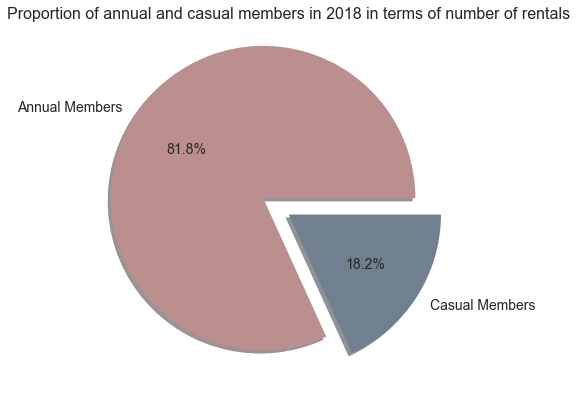

In [187]:
plt.style.use('seaborn') #set seaborn style for graphs in this analysis

members.plot(kind='pie', figsize=(7,7), autopct='%.1f%%', fontsize=14, legend=False,
             colors=['rosybrown', 'slategrey'], explode=(0.2,0), 
            shadow=True, labels=['Annual Members', 'Casual Members'])

plt.title('Proportion of annual and casual members in 2018 in terms of number of rentals', 
          fontdict={'fontsize':16})
plt.axis('off')

Throughout the year, the breakdown is as in the chart above. However, it is possible that the participation of individual groups varies depending on the period.

In [188]:
#creating bins weekly for grouping and cutting data
weekly_bins = pd.date_range('2017-12-31', '2018-12-31', freq='W')

#creating pivot table to find the number of rentals depending of type of user
by_member = df.pivot_table(index=pd.cut(df['trip_start_time'], weekly_bins), 
               columns='user_type', aggfunc='count', values='to_station_id')

by_member.head()

user_type,Annual Member,Casual Member
trip_start_time,,
"(2017-12-31, 2018-01-07]",4660,83
"(2018-01-07, 2018-01-14]",8199,178
"(2018-01-14, 2018-01-21]",10344,281
"(2018-01-21, 2018-01-28]",13391,574
"(2018-01-28, 2018-02-04]",10546,375


In [189]:
#changing absolute numbers to their shares
for index, row in by_member.iterrows():
    suma = row[0] + row[1]
    row['Annual Member'] = round(row[0] / suma, 3)
    row['Casual Member'] = round(row[1] / suma, 3)

by_member.head()

user_type,Annual Member,Casual Member
trip_start_time,,
"(2017-12-31, 2018-01-07]",0,0
"(2018-01-07, 2018-01-14]",0,0
"(2018-01-14, 2018-01-21]",0,0
"(2018-01-21, 2018-01-28]",0,0
"(2018-01-28, 2018-02-04]",0,0


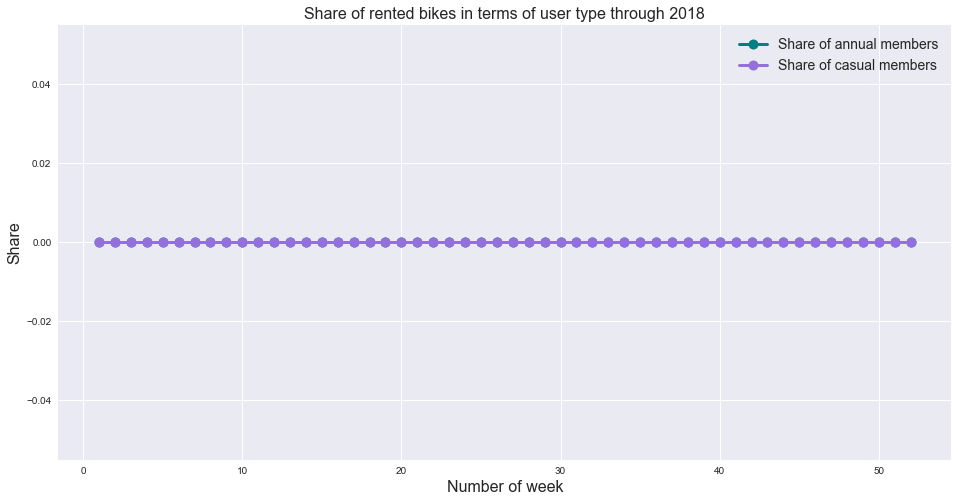

In [190]:
plt.figure(figsize=(16,8))
xticks = range(1, len(by_member.index)+1) 

#create plots for annual and casual members
plt.plot(xticks, by_member['Annual Member'], '-o', lw=3, color='teal',
         markersize=10, label='Share of annual members')
plt.plot(xticks, by_member['Casual Member'], '-o', lw=3, color='mediumpurple',
         markersize=10, label='Share of casual members') 

plt.xlabel('Number of week', fontdict={'fontsize':16})
plt.ylabel('Share', fontdict={'fontsize':16})
plt.title('Share of rented bikes in terms of user type through 2018', fontdict={'fontsize':16})
plt.legend(prop={'size':14})

The chart shows that in the autumn, winter and early spring periods, those paying the annual subscription account for about 90% of all rides. In summer, probably due to higher temperature, the proportion of these people decreases in favor of casual riders.

# Ride times

Another thing to analyze is the ride time, i.e. the difference between the time of renting the bike and returning it.

In [191]:
#filter for 30-minutes rides
half_hour = df['trip_duration_seconds'] > 30 * 60

total_time = datetime.timedelta(seconds=int(df['trip_duration_seconds'].sum()))
more_than_30 = datetime.timedelta(seconds=int(df[half_hour]['trip_duration_seconds'].sum()))

print('Total time:\t\t', total_time)
print('Time above 30 min:\t', more_than_30)

Total time:		 21432 days, 9:39:08
Time above 30 min:	 6553 days, 18:31:47


The sum of the time for which the bikes were borrowed is 21,432 days, i.e. about 59.5 years. 

Based on the duration of the loan, it is possible to partially estimate the company's revenues. There is no data on the number of people paying the subscription, but one can calculate the amount that is due for keeping the bike more than half hour - in both cases, i.e. in the case of an annual subscription, as well as in the case of casual riders, the price includes only the first 30 minutes of riding - each subsequent started half an hour costs the user $ 4.

In [192]:
#to find out the revenue I divide each time by 30-minutes intervals 
#and subtract 1 (for first free 30-minute ride)
exceeded = df['trip_duration_seconds'] / (30 * 60) - 1

#rounding up and summing
income = exceeded.apply(lambda x: math.ceil(x)).sum() * 4
print('Based solely on overage fees, BikeShare earned {} $.'.format(income))

Based solely on overage fees, BikeShare earned 1085100 $.


In [193]:
#average rental time
mean_time = datetime.timedelta(seconds=int(df['trip_duration_seconds'].mean()))
print('Mean time in seconds is {}, which means {}.'.format(mean_time.seconds, str(mean_time)))

Mean time in seconds is 962, which means 0:16:02.


Text(0.5, 1.0, 'Time of rentals in seconds in 2018')

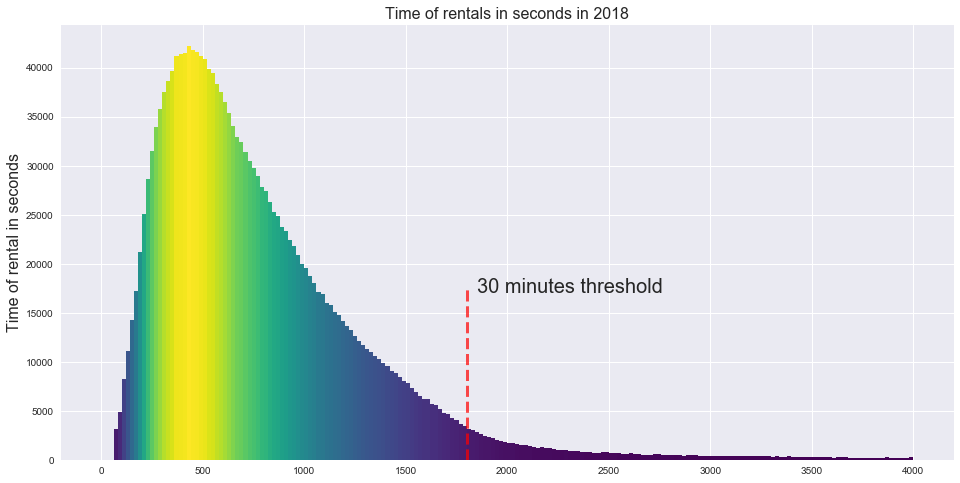

In [194]:
time_bins = np.linspace(0, 4000, 201)
plt.figure(figsize=(16,8))

#set colormap for nice visualization
cm = plt.cm.get_cmap('viridis')

n, bins, patches = plt.hist(df['trip_duration_seconds'], time_bins)

#loop to get diffrent color for each bar of the histogram
col = (n-n.min())/(n.max()-n.min())
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

#plotting additional comment with extra line
plt.plot([30*60, 30*60], [0, 17500], 'r--', lw=3, alpha=0.7)
plt.annotate('30 minutes threshold', xy=(1850,17000), size=20)

plt.ylabel('Time of rental in seconds', fontdict={'fontsize':16})
plt.title('Time of rentals in seconds in 2018', fontdict={'fontsize':16})

The histogram presents values indicating the time of renting a bike. It can be seen that although the average rental time is 962 seconds, the most people rented bikes for about 450 seconds (7.5 minutes). What's more, compared to all rides, rides exceeding 30 minutes are a very small part, and as extreme values cause a significant deviation of the average.

# Day and time

Another thing is to analyze bike rentals depending on the day and time. Let's start by checking how rentals varies through the year.

In [195]:
#creating daily bins to cut and group data
daily_bins = pd.date_range('2018-01-01', '2018-12-31', freq='D')

In [196]:
daily_rentals = df.groupby(pd.cut(df['trip_start_time'], daily_bins, 
                                  right=False))['user_type'].count()

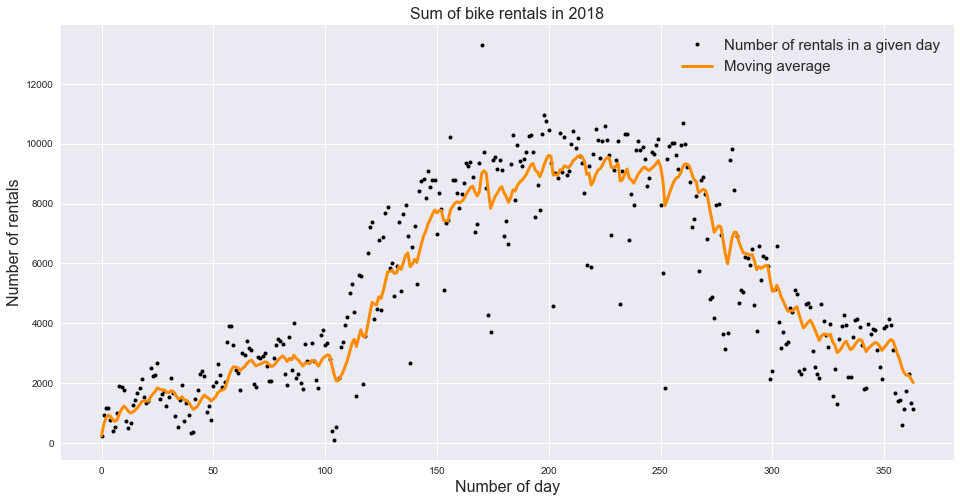

In [197]:
xticks=range(len(daily_rentals.index))
plt.figure(figsize=(16,8))

plt.plot(xticks, daily_rentals, 'o', markersize=4, color='black',
         label='Number of rentals in a given day')
plt.plot(xticks, daily_rentals.ewm(7).mean(), lw=3, color='darkorange',
         label='Moving average')

plt.title('Sum of bike rentals in 2018', fontdict={'fontsize':16})
plt.xlabel('Number of day', fontdict={'fontsize':16})
plt.ylabel('Number of rentals', fontdict={'fontsize':16})
plt.legend(prop={'size':15})

The above chart shows the sum of rentals each day throughout the year. As you can see from the 7-day average line, most people use Bike Share in the summer. Interestingly, however, even in winter months, the values may reach up to 4000 rentals per day.

In [198]:
#creating additional category (even though I do not need to) 
#to get name of days in correct order on next plots
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#adding new column to the original dataset indicating the name of the day
df['day'] = df['trip_start_time'].dt.day_name()
df['day'] = pd.Categorical(df['day'], categories=day_names, ordered=True)

Another thing is to check how the values change depending on the day of the week. 

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

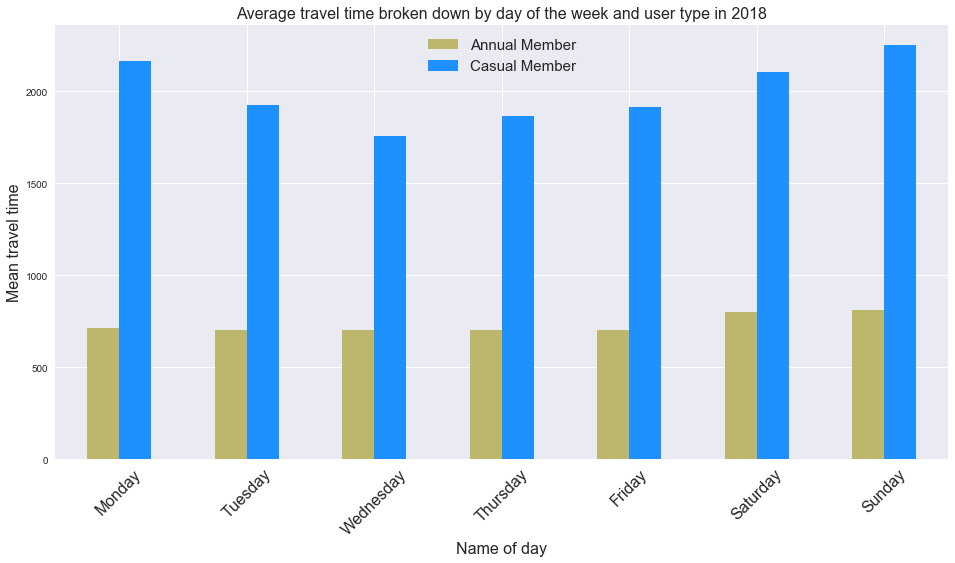

In [199]:
#creating groupby object that calculate the mean travel time based 
#on day of the week and user type
time_grouped = df.groupby(['day', 'user_type'])['trip_duration_seconds'].mean()

#unstacking data with multiindex to get barplot with two bars for each day
time_grouped.unstack().plot(kind='bar', figsize=(16,8), color=['darkkhaki', 'dodgerblue'])

plt.legend(loc='best', prop={'size':15})
plt.title('Average travel time broken down by day of the week and user type in 2018',
          fontdict={'fontsize':16})
plt.xlabel('Name of day', fontdict={'fontsize':16})
plt.ylabel('Mean travel time', fontdict={'fontsize':16})
plt.xticks(size=16, rotation=45)

As for the travel time itself, in the case of subscribers, the time does not differ significantly depending on the day of the week. However, for casual members, the average ride time is about twice as high and is the highest on weekends and Mondays.

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

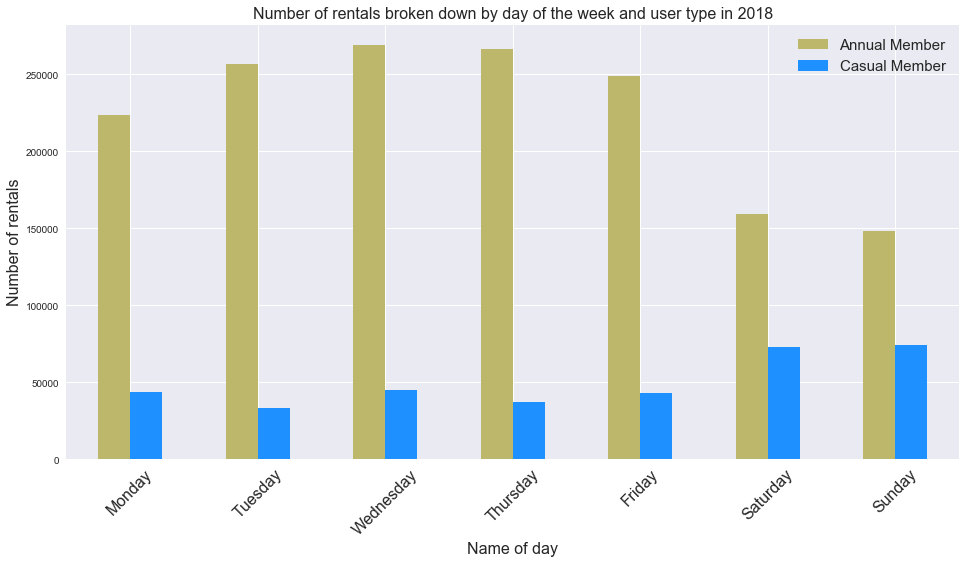

In [200]:
#creating groupby object that sums the number of rides based 
#on day of the week and user type
rentals_grouped = df.groupby(['day', 'user_type'])['user_type'].count()
rentals_grouped.unstack().plot(kind='bar', figsize=(16,8), color=['darkkhaki', 'dodgerblue'])

plt.legend(loc='best', prop={'size':15})
plt.title('Number of rentals broken down by day of the week and user type in 2018',
          fontdict={'fontsize':16})
plt.xlabel('Name of day', fontdict={'fontsize':16})
plt.ylabel('Number of rentals', fontdict={'fontsize':16})
plt.xticks(size=16, rotation=45)

In the case of the number of rentals, the numbers are completely different - subscribers have a much larger mean number. Moreover, this number drops significantly on weekends, suggesting that such people use bikes mainly to travel to and from work.

In [201]:
#adding new column to the original dataset indicating the hour of the beggining of each ride
df['hour'] = df['trip_start_time'].dt.hour

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

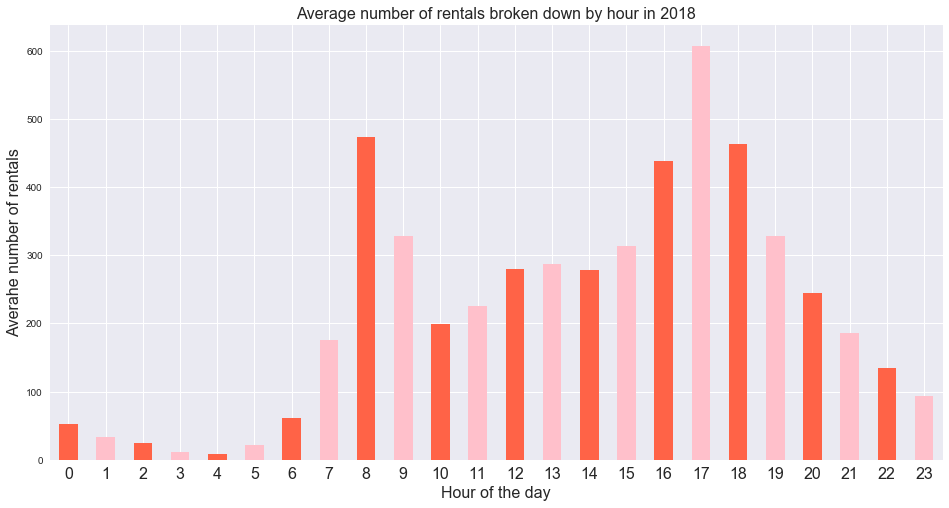

In [202]:
#creating groupby object that sums the average number of rides based on hour of the day 
rentals_by_hour = df.groupby(['hour'])['user_type'].count() / 365

rentals_by_hour.plot(kind='bar', figsize=(16,8), color=['tomato', 'pink'])

plt.title('Average number of rentals broken down by hour in 2018',
          fontdict={'fontsize':16})
plt.xlabel('Hour of the day', fontdict={'fontsize':16})
plt.ylabel('Averahe number of rentals', fontdict={'fontsize':16})
plt.xticks(size=16, rotation=0)

The coclusion to use bikes primarily for work-related travels is also confirmed by the average number of bicycle rentals depending on the time of day. It is obvious that there are more of them during the daytime, and not at nighttime, but a significant increase in the number of rentals in the morning (approx. 8) and in the afternoon (approx. 17) can be observed. This information can be important from the perspective of planning the demand for bicycles and their hourly distribution.

# Bike stations

In order to properly plan the demand for bicycles, it is also important to know which locations are the most popular among users.

In [203]:
#creating pivot table that counts the total number of rides depending on their strarting station 
station_popularity = df.pivot_table(index='from_station_name', values='to_station_name', 
               aggfunc='count').sort_values('to_station_name', ascending=False)
station_popularity.index.name = 'Station'
station_popularity.columns = ['Most popular Bike Share stations by number of rentals in 2018']

#printing top-ten monst popular station in 2018
station_popularity.head(10)

,Most popular Bike Share stations by number of rentals in 2018
Station,
York St / Queens Quay W,24017
Bay St / Queens Quay W (Ferry Terminal),22743
Union Station,19869
Bay St / Wellesley St W,19184
Sherbourne St / Wellesley St E,19131
Front St W / Blue Jays Way,17282
Princess St / Adelaide St E,17089
Dundas St W / Yonge St,17054
Bay St / College St (East Side),16965


Currently analyzed data does not have information on the location of individual stations, but this is generally available information - downloading additional data may allow additional analysis.

In [204]:
#API source: https://open.toronto.ca/dataset/bike-share-toronto/
import requests
import json
req = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
stations = pd.DataFrame(data=json.loads(req.content)['data']['stations'])

#saving downloaded data for backup reasons
stations.to_csv('bike_stations_toronto.csv')

stat = stations[['station_id', 'lat', 'lon']]
stat = stat.set_index('station_id')

In [205]:
stat.head()

,lat,lon
station_id,,
7000,43.639832,-79.395954
7001,43.647992,-79.370907
7002,43.667333,-79.399429
7003,43.667158,-79.402761
7004,43.656518,-79.389099


In [206]:
#creating dictionary for easy changing data types
dtype = dict(from_station_id=str, to_station_id=str)

#adding new columns to the original dataset and changing their names to be more self-explanatory
df = pd.merge(df.astype(dtype), stat, how='left', left_on='from_station_id', 
         right_index=True)
df.rename({'lat' : 'from_latitude', 'lon' : 'from_longitude'}, axis=1, inplace=True)

#adding new columns to the original dataset and changing their names to be more self-explanatory
df = pd.merge(df.astype(dtype), stat, how='left', left_on='to_station_id', 
         right_index=True)
df.rename({'lat' : 'to_latitude', 'lon' : 'to_longitude'}, axis=1, inplace=True)

From the company’s management’s perspective, it may be important how far the average distance users travel. Based on this data, it is not possible to accurately calculate this, but it can be assumed that users rode in a straight line from the start to the end.

In [207]:
#creating function that calculate distance based on Haversine formula
def get_distance(row):
    
    #Haversine formula require coordinates to be changed to radians
    row['from_longitude'] = math.radians(row['from_longitude'])
    row['from_latitude'] = math.radians(row['from_latitude'])
    row['to_longitude'] = math.radians(row['to_longitude'])
    row['to_latitude'] = math.radians(row['to_latitude'])
    
    dlon = row['to_longitude'] - row['from_longitude']
    dlat = row['to_latitude'] - row['from_latitude']
    
    a = math.sin(dlat/2)**2 + math.cos(row['from_latitude']) * \
     math.cos(row['to_latitude']) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    
    #Earth radius in kilomenetrs, so the returned result is also in kilometers
    r = 6371 
    return c * r

In [208]:
#applying new function
df['distance'] = df.apply(func=get_distance, axis=1)

Text(0.5, 0, 'Distance traveled in kilometers')

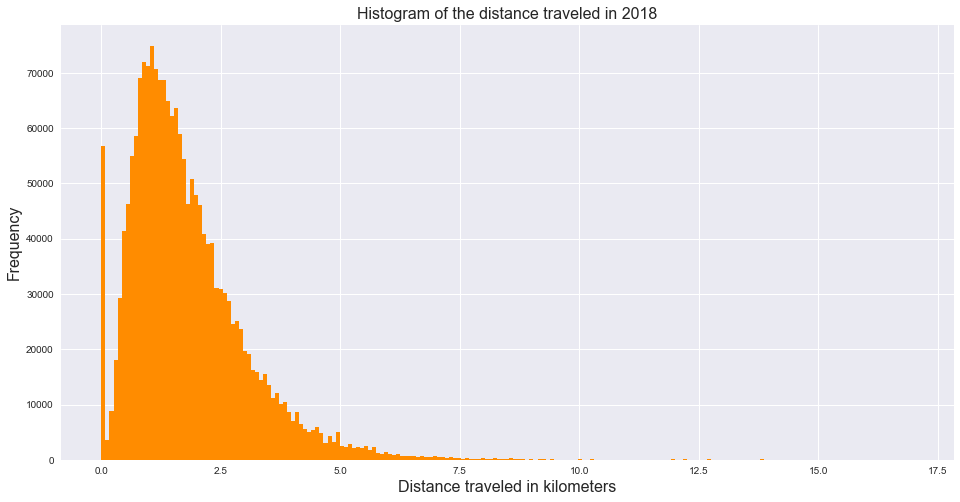

In [209]:
df['distance'].plot(kind='hist', bins=201, figsize=(16,8), color='darkorange')

plt.title('Histogram of the distance traveled in 2018',fontdict={'fontsize':16})
plt.ylabel('Frequency', fontdict={'fontsize':16})
plt.xlabel('Distance traveled in kilometers', fontdict={'fontsize':16})

The largest number of trips in a straight line was less than 2 kilometers.

On the page from which the analyzed data was downloaded, there was a task to analyze how many of all trips are routes that beggins and ends at the same point. Based on the distance traveled, you can filter such a trip (distance covered - 0 kilometers). Although they do not constitute a large share among all journeys, they are clearly marked on the histogram.

Based on location data, a map on which the most used stations will be marked in terms of the number of bike rentals and returns can be created.


In [210]:
#only 2,97% of all rides ends in the same point where they begun
df['distance'].value_counts()[0] / df['distance'].value_counts().sum()

0.02969943573237291

In [211]:
#calculating popularity of all sgtations
map1 = df['from_station_id'].value_counts()
map2 = df['to_station_id'].value_counts()

#merging popularity of stations with their coorinates
map1 = pd.merge(map1, stat, how='left', left_index=True, right_index=True)
map2 = pd.merge(map2, stat, how='left', left_index=True, right_index=True)

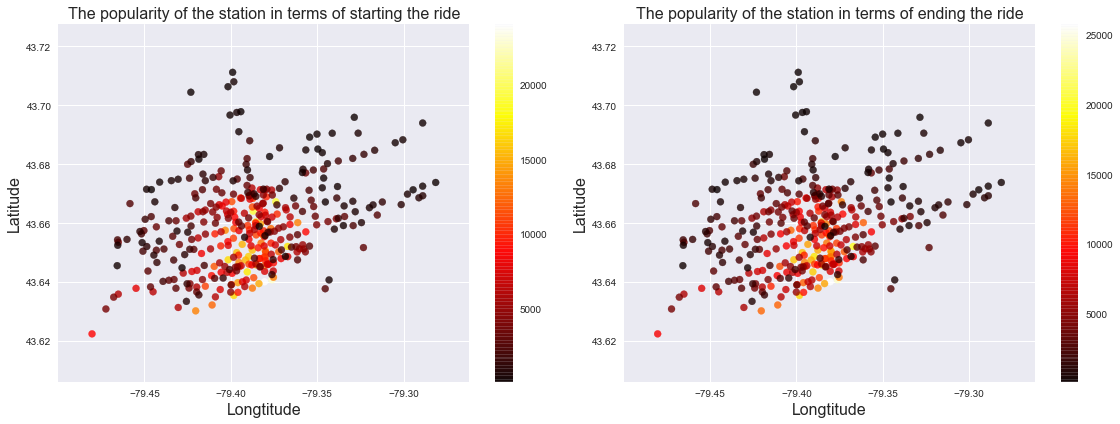

In [212]:
#plotting map no. 1
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.scatter(map1['lon'], map1['lat'], c=map1['from_station_id'], cmap='hot', alpha=0.8)
plt.colorbar()
plt.title('The popularity of the station in terms of starting the ride',fontdict={'fontsize':16})
plt.ylabel('Latitude', fontdict={'fontsize':16})
plt.xlabel('Longtitude', fontdict={'fontsize':16})

#plotting map no. 2
plt.subplot(122)
plt.scatter( map2['lon'], map2['lat'], c=map2['to_station_id'], cmap='hot', alpha=0.8)
plt.colorbar()
plt.title('The popularity of the station in terms of ending the ride',fontdict={'fontsize':16})
plt.ylabel('Latitude', fontdict={'fontsize':16})
plt.xlabel('Longtitude', fontdict={'fontsize':16})

plt.tight_layout()

The above maps show no significant differences between the number of rentals and returns at a given station.

The same will be analyzed based on the morning and afternoon hours - as suggested by the histogram of rentals divided into individual hours. In order to eliminate winter and night, only the May-October period will be taken into account.

In [213]:
#crating popularity values and merging with coordinates for  morning hours
morning1 = df[(df['hour'] >= 6) & (df['hour'] <= 10)]['from_station_id'].value_counts()
morning2 = df[(df['hour'] >= 6) & (df['hour'] <= 10)]['to_station_id'].value_counts()
morning1 = pd.merge(morning1, stat, how='left', left_index=True, right_index=True)
morning2 = pd.merge(morning2, stat, how='left', left_index=True, right_index=True)

#crating popularity values and merging with coordinates for afternoon hours
afternoon1 = df[(df['hour'] >= 15) & (df['hour'] <= 19)]['from_station_id'].value_counts()
afternoon2 = df[(df['hour'] >= 15) & (df['hour'] <= 19)]['to_station_id'].value_counts()
afternoon1 = pd.merge(afternoon1, stat, how='left', left_index=True, right_index=True)
afternoon2 = pd.merge(afternoon2, stat, how='left', left_index=True, right_index=True)

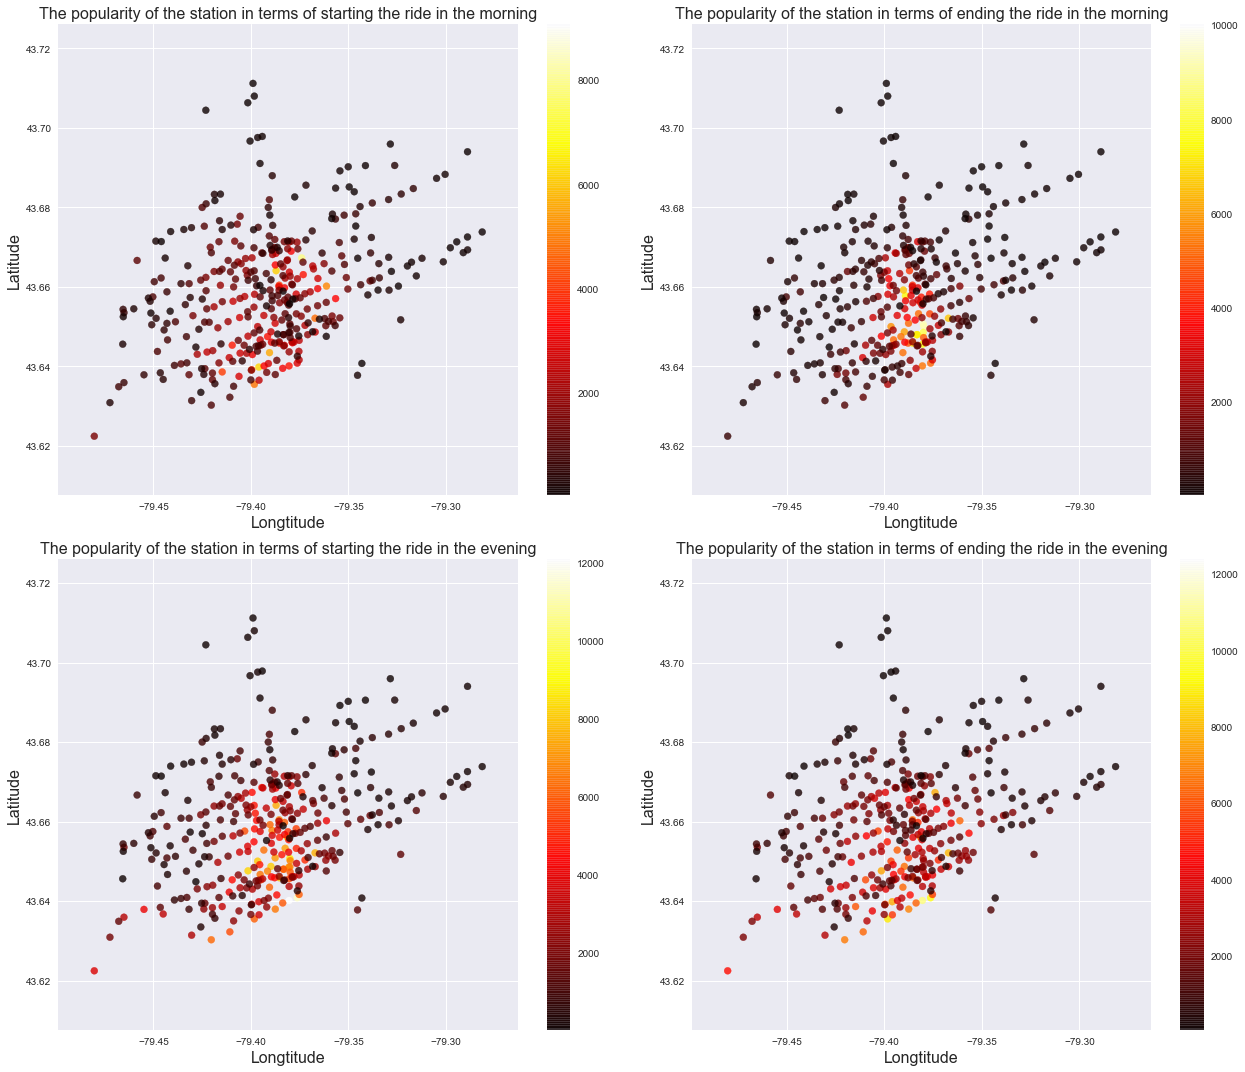

In [214]:
plt.figure(figsize=(18,15))

#plotting map no. 1
plt.subplot(221)
plt.scatter(morning1['lon'], morning1['lat'], 
            c=morning1['from_station_id'], cmap='hot', alpha=0.8)
plt.colorbar()
plt.title('The popularity of the station in terms of starting the ride in the morning',
          fontdict={'fontsize':16})
plt.ylabel('Latitude', fontdict={'fontsize':16})
plt.xlabel('Longtitude', fontdict={'fontsize':16})

#plotting map no. 2
plt.subplot(222)
plt.scatter(morning2['lon'], morning2['lat'], 
            c=morning2['to_station_id'], cmap='hot', alpha=0.8)
plt.colorbar()
plt.title('The popularity of the station in terms of ending the ride in the morning',
          fontdict={'fontsize':16})
plt.ylabel('Latitude', fontdict={'fontsize':16})
plt.xlabel('Longtitude', fontdict={'fontsize':16})

#plotting map no. 3
plt.subplot(223)
plt.scatter(afternoon1['lon'], afternoon1['lat'], 
            c=afternoon1['from_station_id'], cmap='hot', alpha=0.8)
plt.colorbar()
plt.title('The popularity of the station in terms of starting the ride in the evening',
          fontdict={'fontsize':16})
plt.ylabel('Latitude', fontdict={'fontsize':16})
plt.xlabel('Longtitude', fontdict={'fontsize':16})

#plotting map no. 4
plt.subplot(224)
plt.scatter(afternoon2['lon'], afternoon2['lat'], 
            c=afternoon2['to_station_id'], cmap='hot', alpha=0.8)
plt.colorbar()
plt.title('The popularity of the station in terms of ending the ride in the evening',
          fontdict={'fontsize':16})
plt.ylabel('Latitude', fontdict={'fontsize':16})
plt.xlabel('Longtitude', fontdict={'fontsize':16})

plt.tight_layout()

In this case, the differences are much more significant - it can be seen that in the morning hours bike returns occur in a larger number in the central part of the city. In the afternoon hours the tendency seems to be the opposite - more bikes are rented in the center.

# Number of simultaneous rentals

Another issue is the analysis of the number of bikes available. The above analysis has so far concerned the number of rentals, which is limited by their availability.

In [215]:
#calculating how many rides are active at the same time
active_rides = df[['trip_start_time', 'trip_stop_time']].melt(
    var_name='tag', value_name='datetime').sort_values('datetime')

active_rides['counter'] = active_rides['tag'].map({'trip_start_time' : 1, 
                                                   'trip_stop_time' : -1}).cumsum()
active_rides.set_index('datetime', inplace=True)

In [216]:
active_rides.head()

,tag,counter
datetime,,
2018-01-01 00:47:00,trip_start_time,1
2018-01-01 00:52:00,trip_start_time,2
2018-01-01 00:54:00,trip_stop_time,1
2018-01-01 00:55:00,trip_start_time,2
2018-01-01 00:57:00,trip_start_time,3


In [217]:
#the maximum number of active rentals at the same time was 621
active_rides['counter'].sort_values(ascending=False).head(5)

datetime
2018-05-21 16:47:00    621
2018-05-21 16:47:00    621
2018-05-21 16:47:00    620
2018-05-21 15:29:00    620
2018-05-21 16:47:00    620
Name: counter, dtype: int64

As can be seen from the table, the largest number of concurrent bicycle users was around 620. However, it is difficult to determine whether all the available bikes were used at that time.

Text(0.5, 0, 'Number of active rentals')

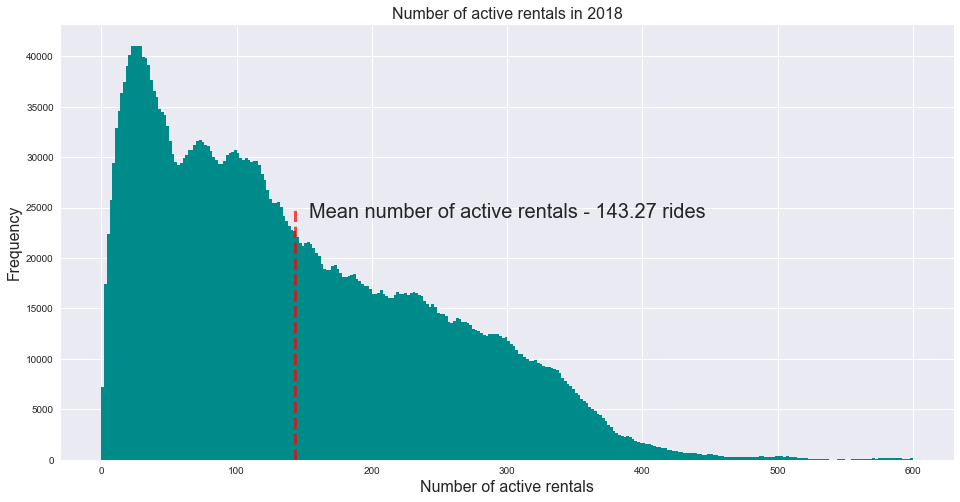

In [218]:
mean_active = active_rides['counter'].mean()

bins = np.linspace(0, 600, 301)

plt.figure(figsize=(16,8))
plt.hist(active_rides['counter'], bins, color='darkcyan')

plt.plot([mean_active, mean_active], [0, 25000], 'r--', lw=3, alpha=0.7)
plt.annotate('Mean number of active rentals - {} rides'
             .format(round(mean_active, 2)), xy=(mean_active+10,24000), size=20)

plt.title('Number of active rentals in 2018',
          fontdict={'fontsize':16})
plt.ylabel('Frequency', fontdict={'fontsize':16})
plt.xlabel('Number of active rentals', fontdict={'fontsize':16})

However the histogram shows, that the maximum number of 620 rented bikes at the same time was very rare. About 30 bikes were mainly rented. The above data were constructed on the basis of comprehensive data, i.e. including winter and night time.

In [219]:
#creating filter of May-October days
summer_filter1 = active_rides.index > '2018-05-01'
summer_filter2 = active_rides.index < '2018-11-01'

In [220]:
#filtering only May-October days and 7-21 hours
summer_days = active_rides[summer_filter1&summer_filter2].between_time('07:00:00', '21:00:00')

Text(0.5, 0, 'Number of active rentals')

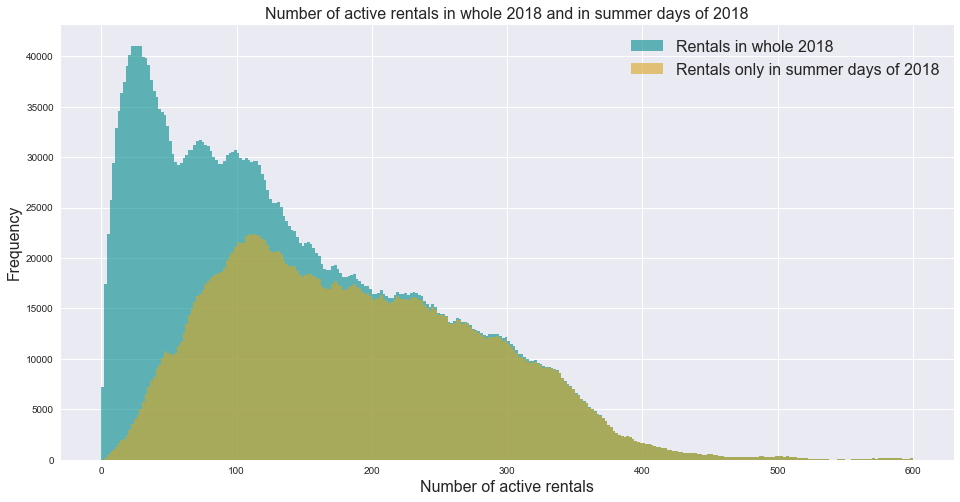

In [221]:
bins = np.linspace(0, 600, 301)

plt.figure(figsize=(16,8))
plt.hist(active_rides['counter'], bins, alpha=0.6, label='Rentals in whole 2018', color='darkcyan')
plt.hist(summer_days['counter'], bins, alpha=0.6, label='Rentals only in summer days of 2018', 
         color='goldenrod')

plt.legend(fontsize=16)
plt.title('Number of active rentals in whole 2018 and in summer days of 2018',
          fontdict={'fontsize':16})
plt.ylabel('Frequency', fontdict={'fontsize':16})
plt.xlabel('Number of active rentals', fontdict={'fontsize':16})

While showing the previous graph with the histogram created solely on the basis of the summer season and daytime hours, it can be noticed that about 100 bikes are used at the same time. Considering the above, one should ask the question whether it is in the interest of the company to increase the number of available bicycles, if in given circumstances there are not so many people willing to rent them.

# Weather / correlation

One may wonder what factors most affect the number of bike rentals. As an example, the correlation of their numbers with temperature will be examined.

In [222]:
#source: https://toronto.weatherstats.ca/download.html
weather = pd.read_csv('toronto_weather.csv', 
                      usecols=['date_time_local', 'temperature', 'windchill', 'wind_speed'])

In [223]:
#removing timezone infos that raise warnings, but are irrelevant in this - single city - case
weather['date_time_local'] = weather['date_time_local'].str.replace('EST', '')
weather['date_time_local'] = weather['date_time_local'].str.replace('EDT', '')

In [224]:
#changing dtype to datetime and creating filtering only 2018
weather['date_time_local'] = weather['date_time_local'].astype('datetime64[ns]')
filtr1 = weather['date_time_local'] <= '2019-01-01'
filtr2 = weather['date_time_local'] >= '2018-01-01'

weather.drop(weather[~(filtr1 & filtr2)].index, inplace=True)

weather = weather.sort_values('date_time_local').set_index('date_time_local')

In [225]:
weather.head()

,wind_speed,temperature,windchill
date_time_local,,,
2018-01-01 00:00:00,9.0,-19.5,-26.0
2018-01-01 01:00:00,12.0,-21.7,-30.0
2018-01-01 02:00:00,9.0,-19.3,-26.0
2018-01-01 03:00:00,4.0,-20.3,-24.0
2018-01-01 04:00:00,4.0,-19.9,-23.0


In this case, only summer days and hours of 6-22 will be taken into account.

In [226]:
#creating hourly bins to cut and group data 
hourly_bins = pd.date_range('2018-05-01', '2018-11-01', freq='H')

hourly_rentals = df.groupby(pd.cut(df['trip_start_time'], hourly_bins, 
                                  right=False))['user_type'].count()

In [227]:
hourly_rentals.index = hourly_bins[:-1]

In [228]:
hourly_rentals = hourly_rentals[(hourly_rentals.index.hour > 6) & (hourly_rentals.index.hour < 22)]

In [229]:
weather = pd.merge(hourly_rentals, weather, left_index=True, right_index=True, how='left')
weather.rename({'user_type' : 'rentals'}, axis=1, inplace=True)

In [230]:
weather[['rentals', 'temperature']].corr()

,rentals,temperature
rentals,1.000000,0.372588
temperature,0.372588,1.000000


The correlation of number of rentals with temperature is not clear - 0.372588.

No handles with labels found to put in legend.


Text(0.5, 0, 'Number of rentals')

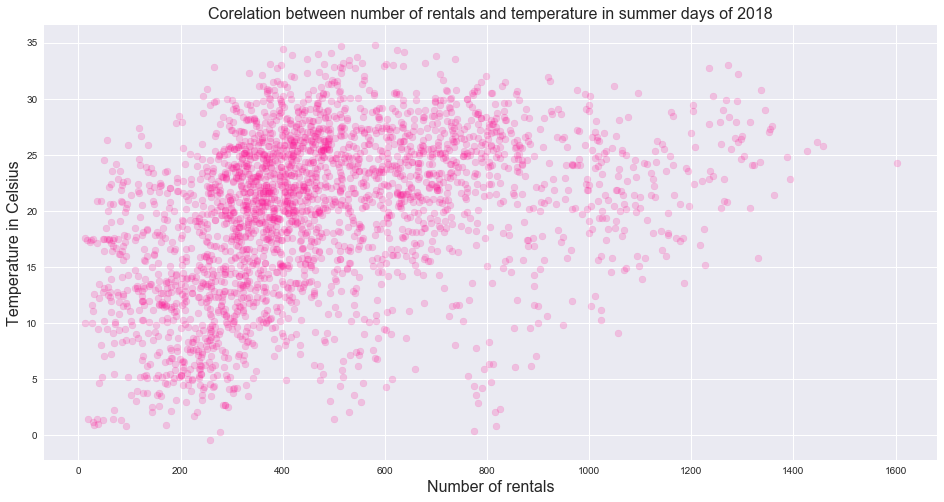

In [231]:
plt.figure(figsize=(16,8))
plt.scatter(weather['rentals'], weather['temperature'], alpha=0.2, color='deeppink')

plt.legend(fontsize=16)
plt.title('Corelation between number of rentals and temperature in summer days of 2018',
          fontdict={'fontsize':16})
plt.ylabel('Temperature in Celsius', fontdict={'fontsize':16})
plt.xlabel('Number of rentals', fontdict={'fontsize':16})

As can been seen on corelation graph above, there is no straight correlation line, hence correlation between temperature and number of rentals exist, but is not very strong. One should look for other, external reasons for changes of number of rental throughout the year.

# Thank you very much! :)